In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService  # type: ignore
import numpy as np
import pandas as pd

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df):
    """
    改进点：
    1. 结合成交量分布和价格位置双重确认
    2. 增加交易意图分析（主动买入/卖出）
    3. 使用动态时间窗口
    """
    # 动态窗口：根据波动率调整回溯期
    volatility = df['close'].pct_change().rolling(96).std()
    
    # 处理NaN和inf问题 - 填充缺失值，避免除以零
    volatility = volatility.fillna(volatility.mean())  # 填充NaN为均值
    volatility = volatility.replace(0, 1e-6)           # 避免除以零
    volatility = np.clip(volatility, 1e-6, None)        # 确保最小正值
    
    # 计算窗口大小并确保为整数
    window_size = (960 / (volatility * 100 + 1))
    window_size = np.nan_to_num(window_size, nan=480)   # 替换NaN为默认值
    window_size = np.clip(window_size, 480, 1440).astype(int)
    
    # 预计算关键指标
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ret = (df['close'] - df['open']) / df['open']
    abs_ret = np.abs(ret)
    buy_power = df['taker_buy_volume'] / df['volume']
    
    # 核心指标：量价确认得分
    # 结合价格变动方向、主动买入比例和交易规模
    S = np.sign(ret) * abs_ret * buy_power * np.log1p(df['volume'])
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 找到有效的起始索引（确保有足够数据）
    start_idx = max(np.max(window_size), 96) + 1
    
    for i in range(start_idx, len(df)):
        w_size = window_size[i]
        start_idx = i - w_size
        end_idx = i - 1
        
        # 提取窗口数据
        window_avg_price = avg_price.iloc[start_idx:end_idx].values
        window_volume = df['volume'].iloc[start_idx:end_idx].values
        window_S = S.iloc[start_idx:end_idx].values
        
        # 按S值降序排序（聪明钱交易在前）
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 动态阈值（基于波动率）
        threshold_ratio = 0.3 - 0.15 * (volatility[i] / volatility.max())  # 波动大时降低阈值
        threshold = np.sum(window_volume) * threshold_ratio
        
        # 识别聪明钱交易
        cum_volume = np.cumsum(sorted_volume)
        smart_mask = cum_volume <= threshold
        
        if np.any(smart_mask):
            # 计算聪明钱VWAP（加权平均价）
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                              sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
            
            # 计算整体VWAP
            all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
            
            # 添加市场状态调整
            if all_vwap > window_avg_price[-96:].mean():  # 近期上涨
                factor_values[i] = smart_vwap / all_vwap
            else:  # 近期下跌
                factor_values[i] = 2 - (smart_vwap / all_vwap)  # 反转因子方向
    
    return pd.Series(-factor_values, index=df.index)

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.026600
   Rank_IC (Spearman): 0.021094
📊 信息比率:
   IR: 0.461683
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130105
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


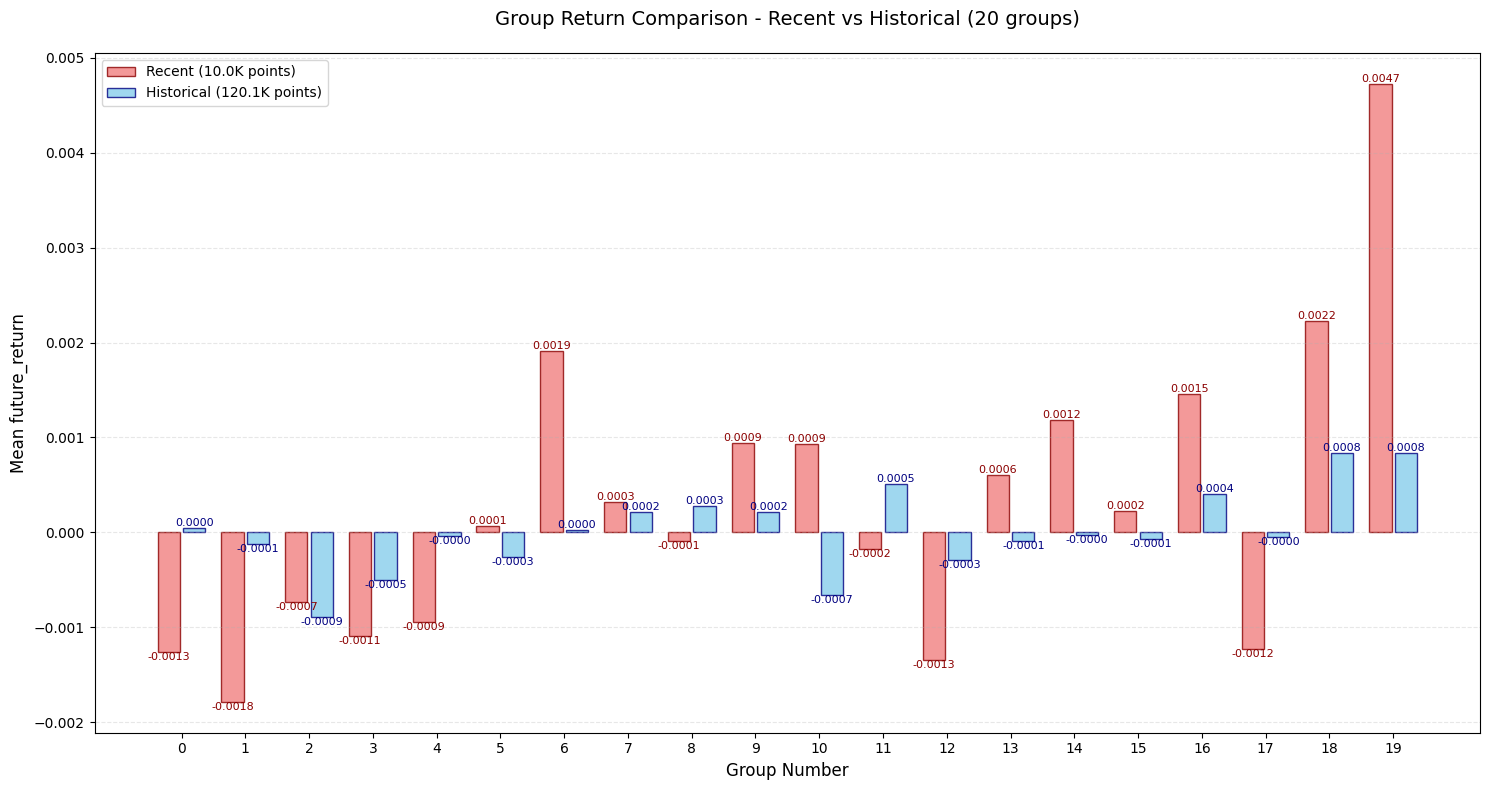

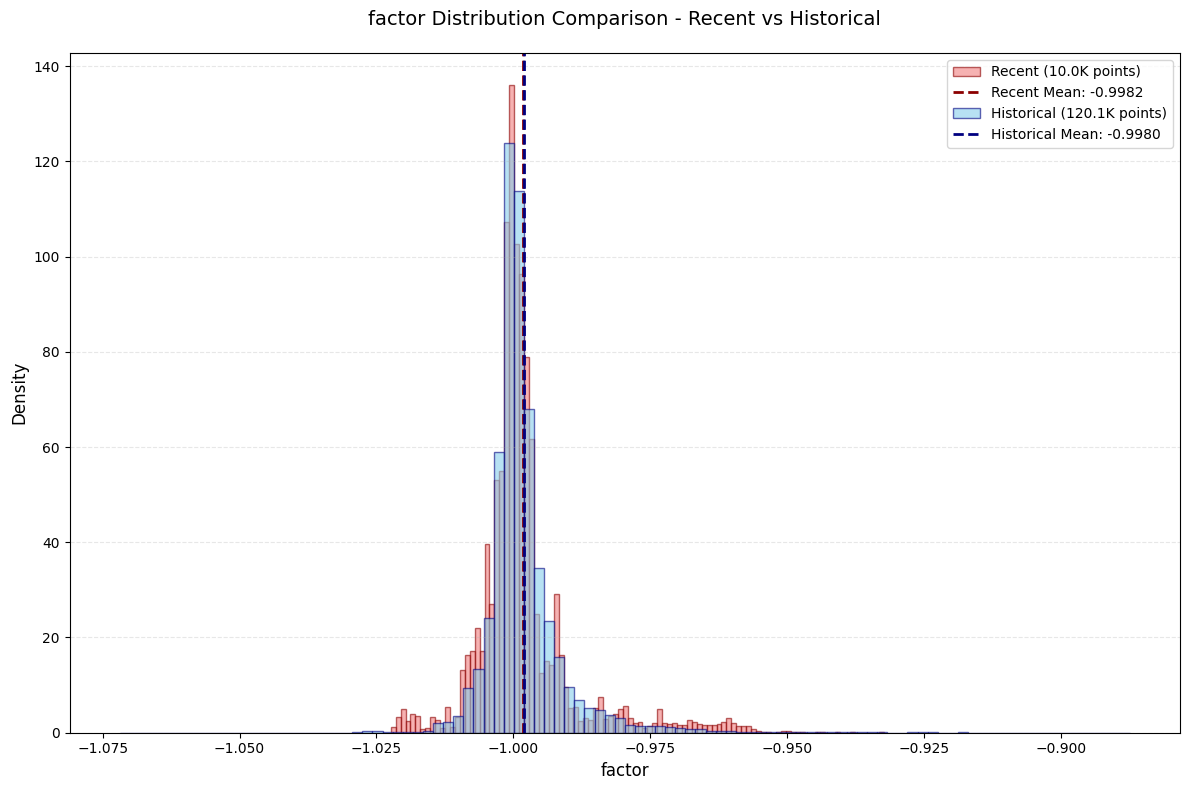

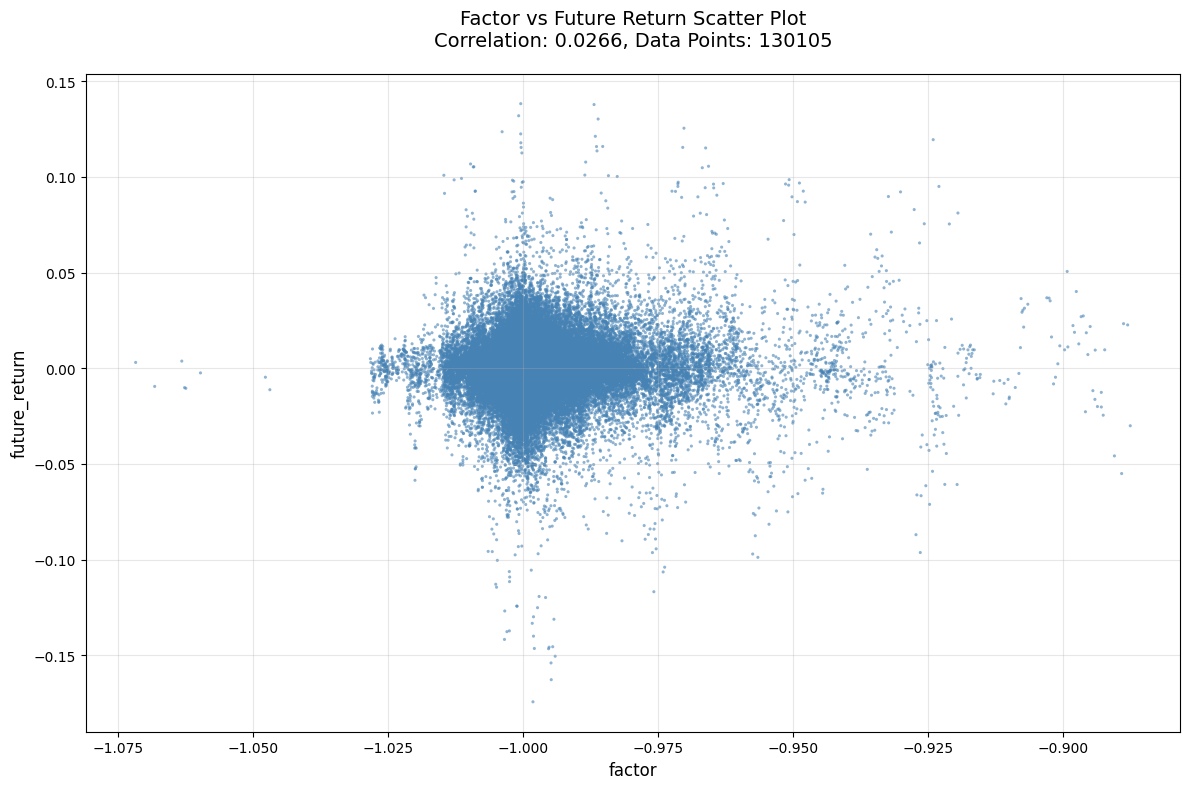

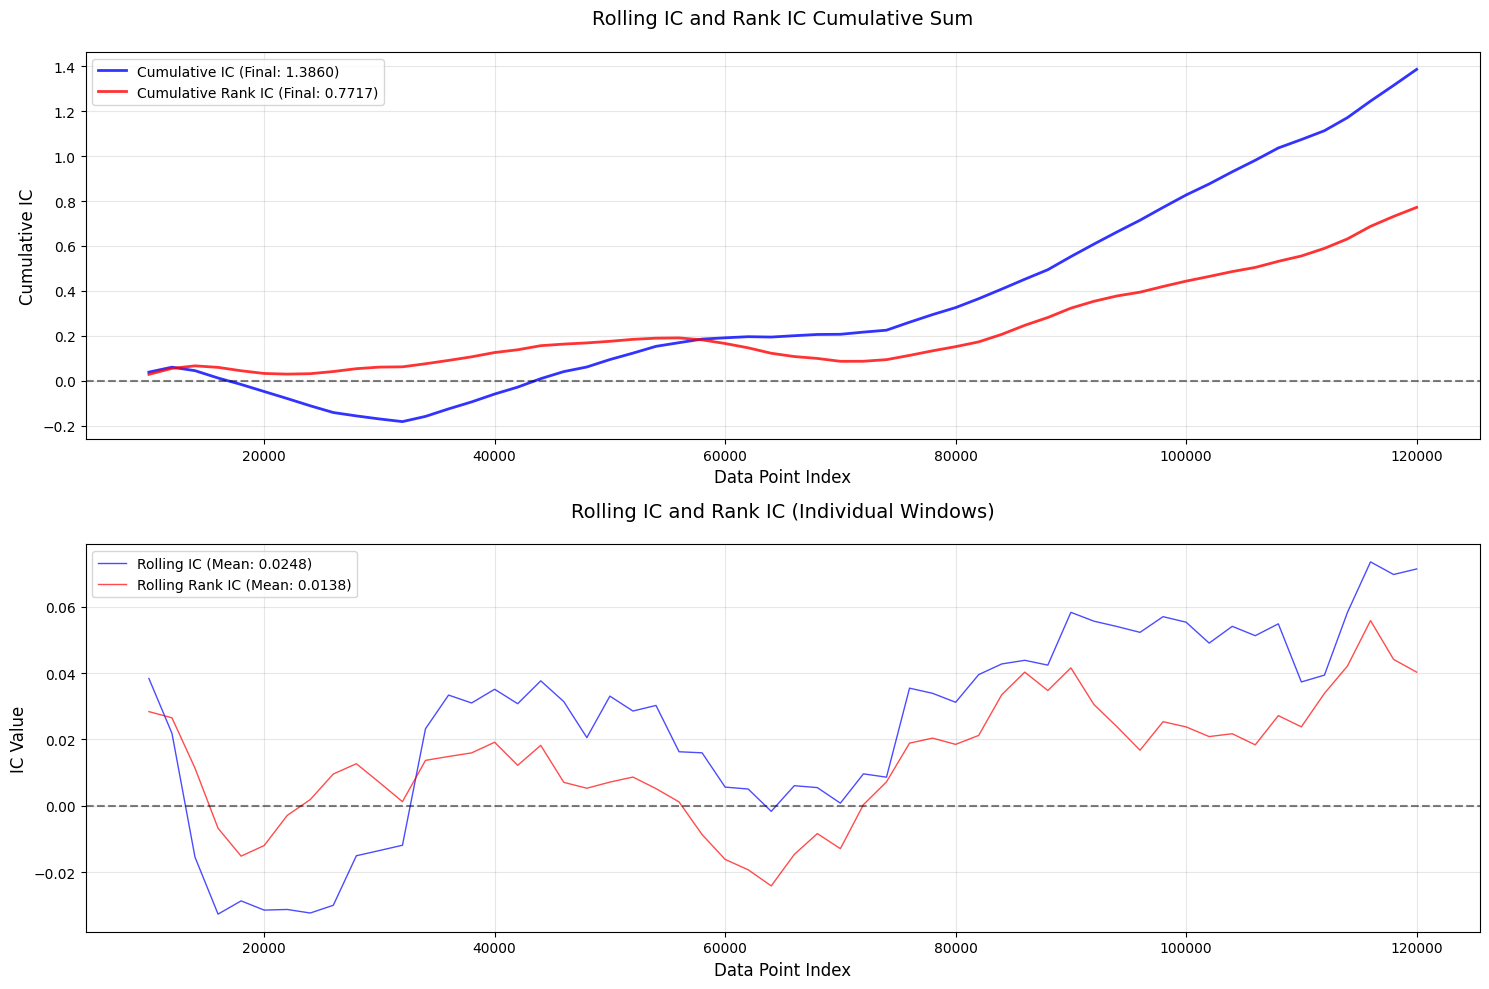

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [7]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.007717843460853629,
 0.00963466886622119,
 0.0069855322281821945,
 0.002809776429227362,
 0.002007388770090794,
 0.030953191343716355,
 0.016477245337997666,
 -0.008195721639436375,
 -0.016994570133038074,
 0.00525060668665594]

In [8]:
print(result)

{'correlation_analysis': {'IC': 0.026599822098685, 'Rank_IC': 0.021093857709250083}, 'information_ratio': {'IR': 0.4616833786683159, 'group_correlations': [0.007717843460853629, 0.00963466886622119, 0.0069855322281821945, 0.002809776429227362, 0.002007388770090794, 0.030953191343716355, 0.016477245337997666, -0.008195721639436375, -0.016994570133038074, 0.00525060668665594], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -1.0718  -1.0063   -1.0100      -0.0002      0.0130   6506
1      -1.0063  -1.0039   -1.0049      -0.0003      0.0114   6505
2      -1.0039  -1.0027   -1.0032      -0.0007      0.0119   6505
3      -1.0027  -1.0020   -1.0023      -0.0005      0.0107   6505
4      -1.0020  -1.0014   -1.0017      -0.0002      0.0103   6506
5      -1.0014  -1.0009   -1.0012      -0.0001      0.0109   6505
6      -1.0009  -1.0005   -1.0007       0.0